# Naive-Bayes model

**Summary:** This notebook responds to the following user story:

***"As a data scientist, I need to apply a Bayesian algorithm to predict the type of advertising that is best suited based on emotion".***

According to the origin-destination matrix, the fields to use are: `Happy`, `Angry`, `Sad`, `Neutral`, `Surprise`, `AdExposure`, `AssetName`, `AssetTypeName`, `Views`.
The field to predict is the probability that the person will be interested in an advertisement P (`AdExposure > 0`).

**Content**
1. **Acquisition and exploratory data analysis** - extraction of the required data.
2. **Feature and Selection Engineering** - data preprocessing and selection of key variables.
3. **Model implementation** - fitting of the selected model to the data.
4. **Error analysis** - analysis of the model's performance through its metrics.

**Requirements**
- PySpark
- The raw data is stored in the `data/` folder
- Libraries are in `environment.yml`
- Notebook running in a local machine

**TODO**

- Pao001 - Apply syntetic data with fixed probabilities --> (done)
- Pao002. Implement Grid Search for tunning hyperparameters --> (review)
- Pao003. Research of evaluation methods for Naive-Bayes model
- Pao004. Another graph that could be implemented instead of the radar chart is a bar chart.

**Links**
- https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3741049972324885/3783546674231736/4413065072037724/latest.html
- https://amunategui.github.io/databricks-spark-bayes/index.html
- https://spark.apache.org/docs/2.2.0/mllib-naive-bayes.html


## 01. Acquisition and exploratory data analysis

### 01.1 Syntetic data acquisition from Winkle table

To work with dataframes in Spark, we need to create a [SparkSession](https://spark.apache.org/docs/latest/sql-getting-started.html)

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("bayes-demo") \
    .getOrCreate()

path = "data/Winkle_ABinBev_synt.csv"

df = spark.read.option("header", True).csv(path)

In [3]:
# Selecting the columns from emotion and advertising category
df_s = df.select("Impressions", "Happy","Anger", "Sad", "Surprise", "Neutral", "AdExposure", "AssetName", "AssetTypeName", "Views", "AssetPlayCount")

In [4]:
# Transforming data str to float
# Emotion
df_s = df_s.withColumn("Impressions", df_s["Impressions"].cast('float'))
df_s = df_s.withColumn("Happy", df_s["Happy"].cast('float'))
df_s = df_s.withColumn("Anger", df_s["Anger"].cast('float'))
df_s = df_s.withColumn("Sad", df_s["Sad"].cast('float'))
df_s = df_s.withColumn("Neutral", df_s["Neutral"].cast('float'))
df_s = df_s.withColumn("Surprise", df_s["Surprise"].cast('float'))

# Advertising
df_s = df_s.withColumn("AdExposure", df_s["AdExposure"].cast('float'))
df_s = df_s.withColumn("Views", df_s["Views"].cast('float'))
df_s = df_s.withColumn("AssetPlayCount", df_s["AssetPlayCount"].cast('float'))

In [ ]:
# Now our data have the proper data type
df_s.printSchema()

### 01.2 Statistical review of the data.

From the statistics of the data, we can observe that:

- The max number of impressions are 10, while the minimum is zero.
- The minimum and maximum values of emotions are in the correct range [0, 1].
- The average number of seconds a person spent viewing an advertisement was 74.70 s ~ 1.25 minutes
- The average number of views of an advertisement was ~ 5
- The advertisements were played an average of ~ 5 times

In [6]:
df_s.describe().toPandas()

,summary,Impressions,Happy,Anger,Sad,Surprise,Neutral,AdExposure,AssetName,AssetTypeName,Views,AssetPlayCount
0,count,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000
1,mean,4.9832857142857145,0.1987214304804802,0.20209047816055162,0.20260238297070776,0.19924524007524763,0.19734047813500677,74.69662328977245,None,None,4.982857142857143,4.936571428571429
2,stddev,3.1552903485542054,0.24230041458459217,0.24230418757933136,0.23900620922158242,0.241183759531921,0.23798131327136646,30.64687128172268,None,None,3.1675582367478934,3.1542666594504443
3,min,0.0,0.0,0.0,0.0,0.0,0.0,1.2678484,Adversiting0,Image,0.0,0.0
4,max,10.0,1.0,1.0,1.0,1.0,1.0,148.62296,Adversiting9,Video,10.0,10.0


However, we can observe that there are no probabilities between (0.5, 1.0) for the columns of emotions.

In [ ]:
df_s.filter("Happy > 0.5 AND Happy < 1.0").show()

### 01.3 Visualization of emotion data

We convert our pyspark dataframe into a pandas dataframe for visualization purposes

In [8]:
df_pandas = df_s.toPandas()

We created a pairplot with the [seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html) library to see the distribution of the sentiment data and visually analyze if there is a relationship between sentiment and the type of advertising.

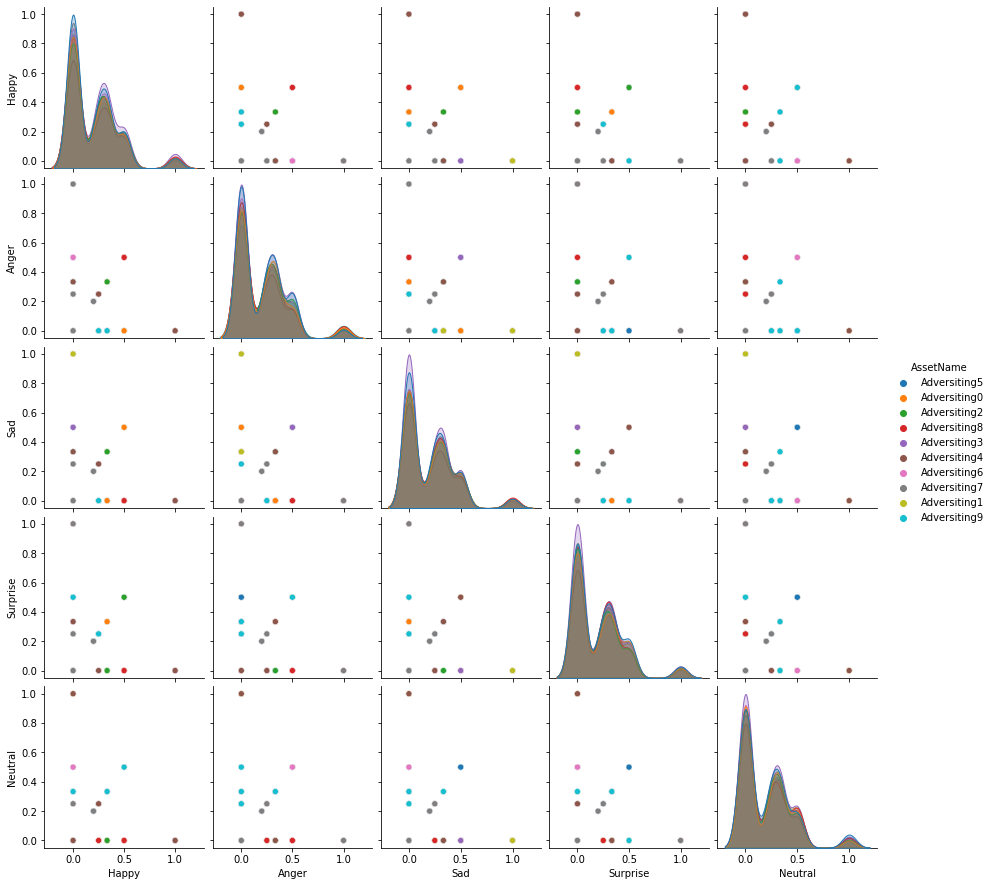

In [9]:
# Pairplot for emotion data
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_pandas[["Happy","Anger", "Sad", "Surprise", "Neutral", "AssetName"]], hue="AssetName")

No pattern between emotions and advertising was observed in the pairplot.

The distribution of the emotion data presents a positive [skewness](https://en.wikipedia.org/wiki/Skewness), most likely due to the lack of probability data between the ranges (0.5, 1). And we can check this by calculating the Fisher-Pearson skewness coefficients for each of the emotion columns. When they are greater than zero, it is said to present a positive skewness.

In [10]:
from pyspark.sql import functions as f

df_s.select(f.skewness(df_s['Happy']),
            f.skewness(df_s['Anger']),
            f.skewness(df_s['Sad']),
            f.skewness(df_s['Surprise']),
            f.skewness(df_s['Neutral'])).show()

+------------------+------------------+------------------+------------------+------------------+
|   skewness(Happy)|   skewness(Anger)|     skewness(Sad)|skewness(Surprise)| skewness(Neutral)|
+------------------+------------------+------------------+------------------+------------------+
|1.3725539785983987|1.3343175420699434|1.3009035892928618|1.3522202823309657|1.3282392232905806|
+------------------+------------------+------------------+------------------+------------------+



From the advertising data, we have a more symmetrical data distribution as shown by the Fisher-Pearson skewness coefficients. `Views` and `AssetPlayCounts` have a more uniform distribution, while `AdExposure` has a more Gaussian distribution. Again, no pattern between the advertising data was observed.

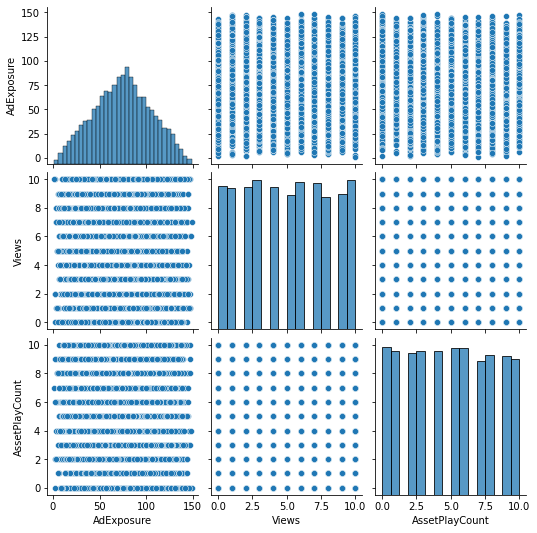

In [11]:
# Pairplot for advertising data
sns.pairplot(df_pandas[["AdExposure", "AssetName", "AssetTypeName", "Views", "AssetPlayCount"]])

In [12]:
df_s.select(f.skewness(df_s['AdExposure']),
            f.skewness(df_s['Views']),
            f.skewness(df_s['AssetPlayCount'])).show()

+--------------------+--------------------+------------------------+
|skewness(AdExposure)|     skewness(Views)|skewness(AssetPlayCount)|
+--------------------+--------------------+------------------------+
|-0.02086863299858...|0.017936816717998398|     0.02132859562749775|
+--------------------+--------------------+------------------------+



Now, when plotting the histogram of the advertisement we see that its frequency for each advertisement is constant, both for video and images.

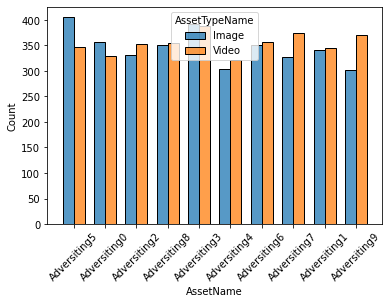

In [13]:
# FIXME: Move legend to the right
hist = sns.histplot(data=df_pandas, x="AssetName", hue="AssetTypeName", multiple="dodge", shrink=.7)
plt.xticks(rotation=45);

### 01.4 Grouping data by emotions

Since we can't sum probabilities, we are going to calculate the total number of `Happy`, `Anger`, `Sad`, `Surprise` and `Neutral` impressions by `assetName`.

For example: `HappyCounts = Happy * Impressions`, and so on.

In [14]:
df_with_counts = df_s.withColumn("HappyCounts", df_s.Happy * df_s.Impressions)
df_with_counts = df_with_counts.withColumn("AngerCounts", df_s.Anger * df_s.Impressions)
df_with_counts = df_with_counts.withColumn("SadCounts", df_s.Sad * df_s.Impressions)
df_with_counts = df_with_counts.withColumn("SurpriseCounts", df_s.Surprise * df_s.Impressions)
df_with_counts = df_with_counts.withColumn("NeutralCounts", df_s.Neutral * df_s.Impressions)

In [ ]:
df_with_counts.show(1)

Let's group the data by advertising and sum the counts for every impression

In [16]:
import pandas as pd

emotions_counts = ["HappyCounts", "AngerCounts", "SadCounts", "SurpriseCounts", "NeutralCounts"]
# Grouping by advertising
df_pandas_counts = df_with_counts.toPandas().groupby("AssetName").sum()[emotions_counts]
# Renaming columns
df_pandas_counts = df_pandas_counts.rename(columns={"HappyCounts": "Happy", "AngerCounts": "Anger", "SadCounts": "Sad", "SurpriseCounts": "Surprise", "NeutralCounts": "Neutral"})

In [17]:
df_pandas_counts

,Happy,Anger,Sad,Surprise,Neutral
AssetName,,,,,
Adversiting0,655.383362,705.383362,703.883362,703.799988,645.549988
Adversiting1,664.000000,734.916687,701.750000,644.333313,737.000000
Adversiting2,696.416687,733.416687,746.666687,656.000000,667.500000
Adversiting3,858.799988,851.133362,783.216675,764.966675,832.883362
Adversiting4,611.816650,551.233337,628.816650,595.900024,596.233337
Adversiting5,689.799988,709.633362,701.966675,748.383362,746.216675
Adversiting6,680.000000,664.583313,731.833313,749.250000,619.333313
Adversiting7,652.833313,766.666687,812.166687,697.750000,727.583313
Adversiting8,723.816650,670.066650,698.150024,620.650024,631.316650


Text(0.5, 1.0, 'Adversiting9')

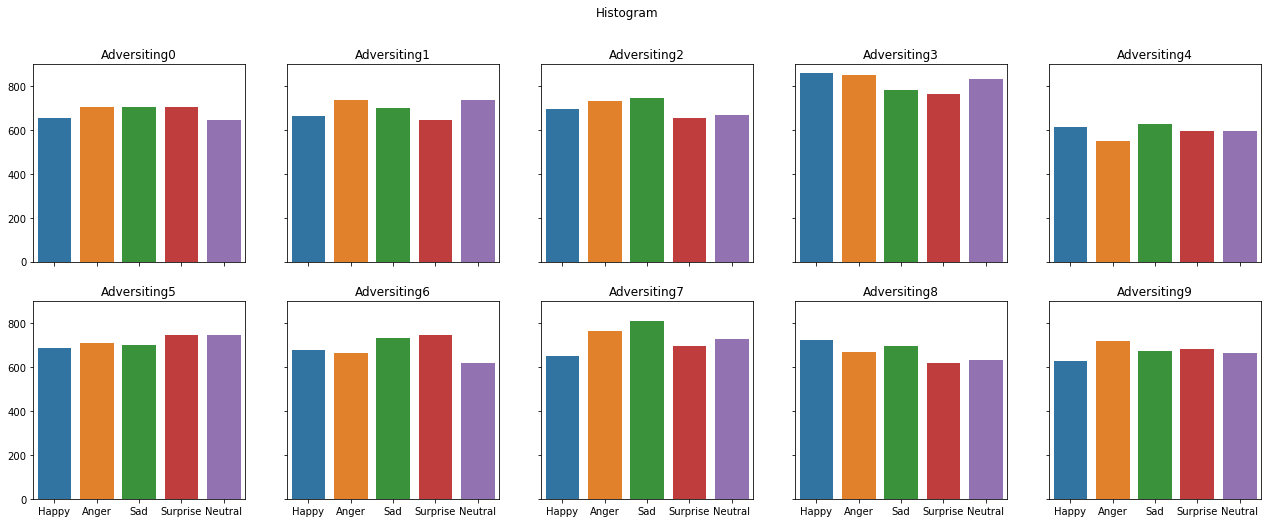

In [18]:
# FIXME: Show x-labels for histogram
fig, axes = plt.subplots(2, 5, sharex=True, figsize=(22,8), sharey=True)
fig.suptitle('Histogram')

ad_0 = df_pandas_counts.loc['Adversiting0']
ad_1 = df_pandas_counts.loc['Adversiting1']
ad_2 = df_pandas_counts.loc['Adversiting2']
ad_3 = df_pandas_counts.loc['Adversiting3']
ad_4 = df_pandas_counts.loc['Adversiting4']
ad_5 = df_pandas_counts.loc['Adversiting5']
ad_6 = df_pandas_counts.loc['Adversiting6']
ad_7 = df_pandas_counts.loc['Adversiting7']
ad_8 = df_pandas_counts.loc['Adversiting8']
ad_9 = df_pandas_counts.loc['Adversiting9']

# Adversiting0
sns.barplot(ax=axes[0,0], x=ad_0.index, y=ad_0.values)
axes[0, 0].set_title(ad_0.name)

# Adversiting1
sns.barplot(ax=axes[0, 1], x=ad_1.index, y=ad_1.values)
axes[0, 1].set_title(ad_1.name)

# Adversiting2
sns.barplot(ax=axes[0, 2], x=ad_2.index, y=ad_2.values)
axes[0, 2].set_title(ad_2.name)

# Adversiting3
sns.barplot(ax=axes[0, 3], x=ad_3.index, y=ad_3.values)
axes[0, 3].set_title(ad_3.name)

# Adversiting4
sns.barplot(ax=axes[0, 4], x=ad_4.index, y=ad_4.values)
axes[0, 4].set_title(ad_4.name)

# Adversiting5
sns.barplot(ax=axes[1, 0], x=ad_5.index, y=ad_5.values)
axes[1, 0].set_title(ad_5.name)

# Adversiting6
sns.barplot(ax=axes[1, 1], x=ad_6.index, y=ad_6.values)
axes[1, 1].set_title(ad_6.name)

# Adversiting7
sns.barplot(ax=axes[1, 2], x=ad_7.index, y=ad_7.values)
axes[1, 2].set_title(ad_7.name)

# Adversiting8
sns.barplot(ax=axes[1, 3], x=ad_8.index, y=ad_8.values)
axes[1, 3].set_title(ad_8.name)

# Adversiting9
sns.barplot(ax=axes[1, 4], x=ad_9.index, y=ad_9.values)
axes[1, 4].set_title(ad_9.name)

We can also use a [radar chart](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html) to visualize how often the cameras detect a certain emotion according to the advertisement. This graph contains the same information

The next block of code is from [here](https://stackoverflow.com/questions/52910187/how-to-make-a-polygon-radar-spider-chart-in-python) and it was used to create the radar chart.

In [19]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

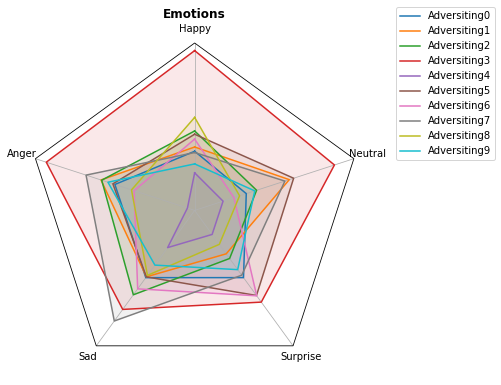

In [20]:
### Creating the radar-chart
emotions = ["Happy","Anger", "Sad", "Surprise", "Neutral"]
N = len(emotions)
theta = radar_factory(N, frame='polygon')

title, case_data = ("Emotions", df_pandas_counts.values)
labels = ["Adversiting0", "Adversiting1", "Adversiting2", "Adversiting3", "Adversiting4", "Adversiting5", "Adversiting6", "Adversiting7", "Adversiting8", "Adversiting9"]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title,  position=(0.5, 1.1), ha='center', weight='bold')

for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.1, label='_nolegend_')
ax.set_varlabels(emotions)
ax.legend(labels, loc=(1.1, 0.65))

plt.show()

### 01.5 Quality review of sentiment and impression data.

- There is no probabilities between (0.5, 1) in the `emotion`, `gender`, and `age` category columns.
- Can the `Impressions` column have zero values? If so, there should be no probabilities in the `emotion`, `gender`, and `age` category columns.

### 01.6 Security review of sentiment and impression data.

### 01.7 Anomaly review of sentiment and impression data.

## 02. Feature Engineering and Selection

### 02.1 Feature Engineering

#### 02.1.1 Feature creation

In [21]:
# Pending
# TODO: is better to use probabilities or the counts for the emotions data?

#### 02.1.2 Transformation of numerical and categorical data

Transforming our categorical data into numerical data

In [22]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Convert target into numerical categories
assetNameIndexer = StringIndexer(inputCol="AssetName", outputCol="label")  # The target MUST be named label
assetTypeNameIndexer = StringIndexer(inputCol="AssetTypeName", outputCol="AssetTypeNameIdx")

pipeline_fe = Pipeline(stages=[assetNameIndexer, assetTypeNameIndexer])
df_s_idx = pipeline_fe.fit(df_s).transform(df_s)
#df_s_idx.show()

### 02.2 Feature Selection

#### 02.2.1 Select the method for feature selection

We will be using Chi Square Selector for this phase

Links:
- https://spark.apache.org/docs/latest/ml-features#chisqselector
- https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.ChiSqSelector.html
- https://antonhaugen.medium.com/feature-selection-with-pyspark-a172d214f0b7
- https://stackoverflow.com/questions/67764576/how-to-check-selected-features-with-pysparks-chisqselector

#### 02.2.2 Implement the method for feature selection

In [23]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=["Impressions", "Happy", "Anger", "Sad", "Surprise", "Neutral", "AdExposure", "Views", "AssetPlayCount", "AssetTypeNameIdx"], outputCol="featuresAll")
vec_df = vec_assembler.transform(df_s_idx)
selector = ChiSqSelector(numTopFeatures=5, featuresCol="featuresAll",
                         outputCol="features", labelCol="label")

#pipeline_fs = Pipeline(stages=[vec_assembler, selector])

result = selector.fit(vec_df).transform(vec_df)

## 03. Model implementation

Links of interest:
- https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
- https://www.datacamp.com/tutorial/naive-bayes-scikit-learn

### 03.1 Split data into training and test

Randomly splitting our dataset in 70-30

In [25]:
# Split dataset randomly into Training and Test sets. Set seed for reproducibility
(trainingData, testData) = result.randomSplit([0.7, 0.3], seed = 190)

#trainingData.cache()
#testData.cache()

print("Rows for training data:", trainingData.count())
print("Rows for testing data:", testData.count())

Rows for training data: 4871
Rows for testing data: 2129


### 03.2 Training of the model

Next, we will use the `VectorAssembler()` to merge our feature columns into a single vector column, which we will be passing into our Naive Bayes model. Again, we will not transform the dataset just yet as we will be passing the VectorAssembler into our ML Pipeline.

In [26]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["Impressions", "Happy", "Anger", "Sad", "Surprise", "Neutral", "AdExposure", "AssetTypeNameIdx", "Views", "AssetPlayCount"], outputCol="features")

We import the library that will train our Naive-Bayes model.

In [27]:
#### Create a Multiclass Naive Bayes Classifier

from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

# Train a NaiveBayes model
nb = NaiveBayes(smoothing=0.1, modelType="multinomial")

# Chain labelIndexer, vecAssembler and NBmodel in a 
pipeline = Pipeline(stages=[assetNameIndexer, assetTypeNameIndexer, vecAssembler, selector, nb])

# Run stages in pipeline and train model
#model = pipeline.fit(trainingData)
model = nb.fit(trainingData)

### 03.2 Making predictions

In [ ]:
# Make predictions on testData so we can measure the accuracy of our model on new data
predictions = model.transform(testData)

# Display what results we can view
predictions.printSchema()

In [29]:
# Select results to view
predictions.select("label", "prediction", "probability").show(10)

22/09/19 13:01:24 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/09/19 13:01:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/09/19 13:01:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       5.0|[0.12258413885948...|
|  3.0|       3.0|[0.06835464474672...|
|  7.0|       1.0|[0.07025609348202...|
|  4.0|       1.0|[0.06938919304065...|
|  2.0|       0.0|[0.13865794450702...|
|  0.0|       0.0|[0.14999125899301...|
|  6.0|       1.0|[0.10374012562220...|
|  1.0|       1.0|[0.06967431965172...|
|  3.0|       1.0|[0.08001341069533...|
|  3.0|       0.0|[0.14915436187929...|
+-----+----------+--------------------+
only showing top 10 rows



### 03.3 Model evaluation

In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                            metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.10709253170502583


The Evaluator is able to use a few metrics such as f1-score, precision, recall, weightedPrecision and weightedRecall.

`evaluator.setMetricName("insert_metric_here")` can be used to change the metric used to evaluate models.

In [31]:
evaluator.explainParam("metricName")

'metricName: metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss) (default: f1, current: accuracy)'

#### 03.3.1 Confusion Matrix

In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Create (prediction, label) pairs
predictionAndLabel = predictions.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print(metrics.confusionMatrix())

/Users/paola/miniconda3/envs/abi/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


DenseMatrix([[58., 47., 45.,  0., 43., 36.,  0., 11.,  4., 14.],
             [64., 48., 27.,  1., 28., 30.,  0.,  9.,  2., 12.],
             [44., 52., 47.,  2., 27., 23.,  0., 10.,  0.,  5.],
             [62., 48., 37.,  6., 15., 24.,  0.,  7.,  3., 11.],
             [60., 40., 31.,  2., 26., 20.,  0.,  6.,  3., 12.],
             [66., 46., 30.,  1., 28., 26.,  0.,  8.,  1.,  7.],
             [62., 52., 27.,  0., 35., 22.,  0.,  5.,  0., 11.],
             [49., 53., 30.,  1., 37., 21.,  0.,  2.,  2.,  9.],
             [55., 49., 34.,  1., 31., 24.,  0.,  7.,  2., 12.],
             [48., 38., 32.,  0., 16., 23.,  0., 10.,  1., 13.]])


## 04. Error analysis

### 04.1 Interpretation of results (scores)

### 04.2 Error identification

### 04.3 Recommendations to improve errors (if applicable)